In [120]:
from IPython.display import display, clear_output
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import datetime
import os
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import random
import time

from scipy.spatial.distance import cosine

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gmplot
from geopy.geocoders import Nominatim
from cheese_utils import (
    RawCheese, get_all_cheeses_url_names, get_cheeses_url_names,
    ingredients, split_columns
)

from nltk.corpus import words

import gensim

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

%matplotlib inline

In [121]:
class RawCheesesDF:
    def __init__(self,all_cheeses_url_names=None,from_file=True,delay=0.1):
        if from_file and os.path.exists("raw_cheeses.csv"):
            self.raw_df = pd.read_csv("raw_cheeses.csv",index_col=0)
        else:
            columns = ["name"]
            self.raw_df = pd.DataFrame(columns=columns)
            self.raw_df.set_index("name")
            for cheese_url in all_cheeses_url_names:
                clear_output(wait=True)
                display("getting cheese {}".format(cheese_url))
                raw_cheese = RawCheese(cheese_url)
                time.sleep(delay)
                self.raw_df = self.raw_df.append(raw_cheese.dict, ignore_index=True)
        self.cooked_df = None
        for split_column in split_columns:
            setattr(self, split_column, None)
        self.docs = None
    
    def simple_tokenizer(self,sentence):
        remove_list = ["'s","milk"]
        sep_list = [" and "," or "]
        for pattern in remove_list:
            sentence = sentence.replace(pattern,"")
        for pattern in sep_list:
            sentence = sentence.replace(pattern,",")
        sentence = sentence.replace(" ",",")
        return [word.strip() for word in sentence.split(",") if len(word)>1]
    
    def column_parser(self,str_instance):
        return [item.strip().lower() for item in str_instance.replace(" and ",",").split(',')]  
        
    def get_split_column(self,column):
        """
            find the names of new columns to be added to self.cooked_df for each column "column" by parsing all the rows
            for that column and finding all the unique keywords
        """
        if getattr(self,column)==None:
            if column=='ingredients':
                return ingredients
            else:
                columns = set()
                for row_str in self.raw_df[column][self.raw_df[column].notnull()]:
                    items = self.column_parser(row_str)#[item.strip().lower() for item in row_str.replace(" and ",",").split(',')]               
                    columns.update(items)
                setattr(self, column, columns)    
                return columns
        else:
            return getattr(self,column)
    
    @property
    def split_columns_dict(self):
        """
            for each initial column name create a dict with key the column name and values the split string
        """
        split_columns_dict = dict.fromkeys(split_columns,[])
        for column in split_columns: 
            split_columns_dict[column] = self.get_split_column(column)
        return split_columns_dict
    
    @property
    def cooked_columns(self):
        """
            collect all the sub-columns or 'cooked' columns into a set
        """
        old_columns = set(self.raw_df.keys()).difference(set(self.split_columns_dict.keys()))
        new_columns = set()
        for x in self.split_columns_dict.values():
            new_columns.update(set(x))
        return old_columns.union(new_columns)

    def get_docs(self):
        """
           pool descriptor from all relevant columns and store them as a string in a dict
        """
        if self.docs==None:
            docs = dict.fromkeys(list(self.raw_df['name']),'')
            pooled_df = self.raw_df.filter(split_columns, axis=1)
            for ix in range(len(pooled_df)):
                docs[self.raw_df['name'][ix]] = self.simple_tokenizer(pooled_df.iloc[ix,:].str.cat(sep=", "))
            self.docs=docs
        return self.docs

    def get_fitted_tfidf(self): 
        tfidf = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x : x,
        preprocessor=lambda x : x,
        token_pattern=None)
        tfidf.fit(list(self.get_docs().values()))
        return tfidf
    
    def get_fitted_cntvect(self): 
        cntvect = CountVectorizer(
        analyzer='word',
        tokenizer=lambda x : x,
        preprocessor=lambda x : x,
        token_pattern=None)
        cntvect.fit(list(self.get_docs().values()))
        return cntvect
    
    def get_cosine_similarity_matrix(
            self,
            feature_extractor='default',
            mean_similarity_thresh=0.1,
            min_description_len=7,
            with_distplot=True,
        ):
        if feature_extractor in ['default','TfidfVectorizer']:
            f_extrct = self.get_fitted_tfidf()
        elif feature_extractor=='CountVectorizer':
            f_extrct = self.get_fitted_cntvect()
        else:
            raise ValueError('blabla')
        features_matrix = f_extrct.fit_transform(list(self.docs.values()))
        cosine = cosine_similarity(features_matrix)
        print(cosine.shape)
        # average similarity threshold 
        mean_sim_vec = np.mean(cosine,axis=0)
        friendly_cheeses_indexes = np.argwhere(mean_sim_vec>=mean_similarity_thresh).flatten()

        n_descriptors = np.array([len(x) for x in list(self.docs.values())])
        detailed_cheeses_indexes = np.argwhere(n_descriptors>=min_description_len).flatten()
        
        filtered_indexes = list(set(friendly_cheeses_indexes).union(set(detailed_cheeses_indexes)))
        print(len(filtered_indexes))
        temp_df = self.raw_df['name'].loc[filtered_indexes].copy()
#         fltrd_features_mat = features_matrix[]
        fltrd_docs = dict.fromkeys(list(self.raw_df['name'].loc[filtered_indexes]),[])
        for key in fltrd_docs.keys():
            fltrd_docs[key] = self.get_docs()[key]
        print(len(fltrd_docs))
        fltrd_features_matrix = f_extrct.fit_transform(list(fltrd_docs.values()))
        fltrd_cosine = cosine_similarity(fltrd_features_matrix)
        return fltrd_cosine, cosine, mean_sim_vec, filtered_indexes, fltrd_docs, features_matrix, f_extrct
    
#     def get_cosine_distance_matrix(self,feature_extractor='default'):
#         if feature_extractor in ['default','TfidfVectorizer']:
#             f_extrct = self.get_fitted_tfidf()
#         elif feature_extractor=='CountVectorizer':
#             f_extrct = self.get_fitted_cntvect()
#         else:
#             raise ValueError('blabla')
#         features_matrix = f_extrct.fit_transform(list(self.docs.values()))
#         cosine = cosine_distances(features_matrix)
#         return cosine

In [122]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

years = [str(x) for x in range(1900,2030)]+[str(x) for x in range(0,100)]

def clean_tokenizer(sentence,**kwargs):
    vocab = kwargs.pop('vocab',None)
    stop = stopwords.words('english') + list(string.punctuation) +["'s"]+years
    if vocab:
        return [i for i in word_tokenize(sentence.lower()) if i in vocab and i not in stop]
    else:
        return [i for i in word_tokenize(sentence.lower()) if i not in stop]

In [123]:
cheeses = RawCheesesDF(None)

### Lets see how sparse this columns are: some columns seem to have very little data and we might as well not use them

In [166]:
n_rows = len(cheeses.raw_df.index)
counts = {}
for key in cheeses.raw_df.keys():
    counts[key]=format(cheeses.raw_df[key].count()/n_rows*100, '.2f')
counts

{'alternative_spellings': '10.93',
 'aroma': '80.70',
 'calcium_content': '2.62',
 'colour': '90.43',
 'country_of_origin': '99.07',
 'family': '43.30',
 'fat_content': '32.42',
 'fat_content_(in_dry_matter)': '0.55',
 'flavour': '94.92',
 'ingredients': '96.99',
 'name': '100.00',
 'producers': '77.80',
 'region': '86.99',
 'rind': '86.93',
 'synonyms': '20.07',
 'texture': '94.31',
 'type': '98.74',
 'vegetarian': '71.13'}

### we'll use the columns that are populated more than 70% and that are not referring to geography or 
We'll use aroma, colour, flavour, ingredients, rind, texture and type

## looking at how to sparse the ingredients

How often do we have cheeses with "and" or "or" in the ingredients

In [167]:
with_or = cheeses.raw_df['ingredients'].str.contains('or',na=False)
with_and = cheeses.raw_df['ingredients'].str.contains('and',na=False)
with_and.__class__

print(np.sum(with_or),"cheeses have 'or' ingredients")
print(np.sum(with_and),"cheeses have 'and' ingredients")
print(np.sum((with_or) & (with_and)),"cheeses have 'or' and 'and' ingredients")

150 cheeses have 'or' ingredients
128 cheeses have 'and' ingredients
16 cheeses have 'or' and 'and' ingredients


In [168]:
for ingredients in cheeses.raw_df['ingredients'][(with_or) & (with_and)]:
    print(ingredients)

pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's and goat's milk
pasteurized or unpasteurized cow's and sheep's milk
pasteurized or unpasteurized goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's, sheep's and water buffalo's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's and sheep's milk


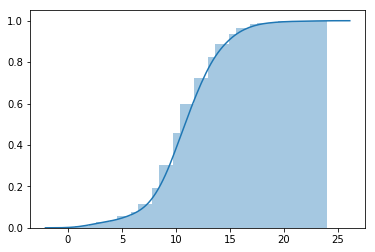

In [169]:
sns.distplot([len(x) for x in cheeses.get_docs().values()],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))


# Qualitative validation
We need some metrics to describe cheeses closeness

### Build cosine similarity matrix and apply hierarchical clustering to features extracted with TfidfVectorizer


/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(1829, 1829)
836
836


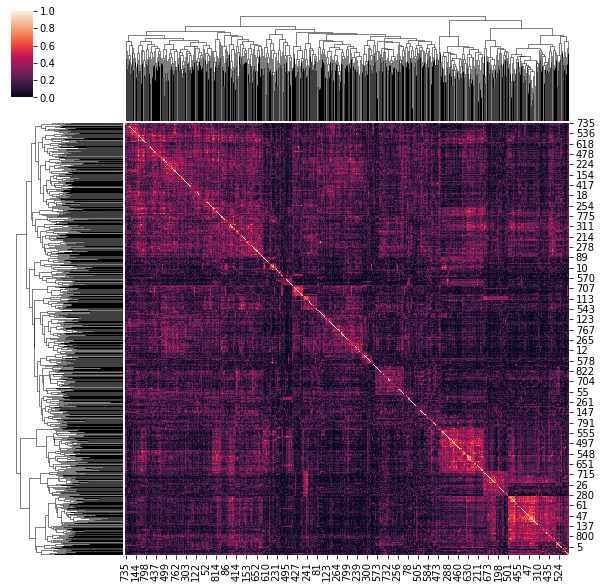

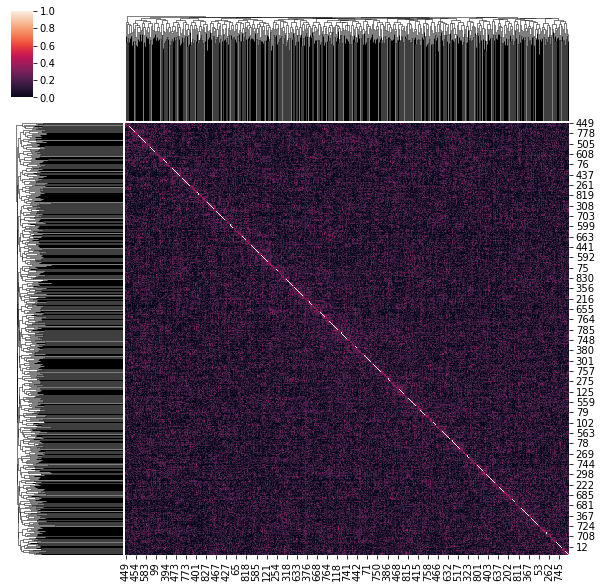

In [170]:
# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))
similiarity_matrix, cosine, mean_sim_vec, filtered_indexes, fltrd_docs, features_matrix, f_extrct = cheeses.get_cosine_similarity_matrix(mean_similarity_thresh=0.2,min_description_len=12)


# create random cheese_docs
random_docs = fltrd_docs.copy()
for key in random_docs.keys():
    n_sample = len(random_docs[key])
    random_docs[key] = random.sample(list(f_extrct.vocabulary_.keys()),n_sample)

#
random_features_matrix = f_extrct.fit_transform(list(random_docs.values()))
random_cosine = cosine_similarity(random_features_matrix)


fig = plt.figure(figsize=(20, 10))
clg = sns.clustermap(similiarity_matrix)
clg = sns.clustermap(random_cosine)

## Defining close and far in chesse space
We're gonna set arbitrary thresholds at the 5th and 95th percentiles to define close and far

/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(1829, 1829)
836
836
really close cheeses have cosine similarity less than 0.34
really far apart cheeses have cosine similarity greater than 0.05


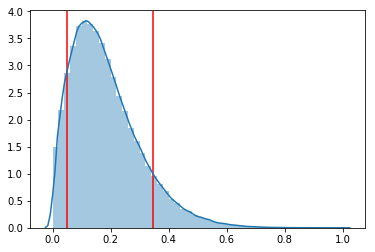

In [171]:
similiarity_matrix, cosine, mean_sim_vec, filtered_indexes, fltrd_docs, features_matrix, f_extrct = cheeses.get_cosine_similarity_matrix(feature_extractor='TfidfVectorizer',mean_similarity_thresh=0.2,min_description_len=12)

vec = similiarity_matrix.flatten()
index = np.argwhere(vec>=1)
y = np.delete(vec, index)
hplot = sns.distplot(y)
close_thresh = np.percentile(y, 90, axis=0)
far_thresh = np.percentile(y, 10, axis=0)
plt.vlines(close_thresh, ymin=0, ymax=4,colors='r')
plt.vlines(far_thresh, ymin=0, ymax=4,colors='r')
print("really close cheeses have cosine similarity less than {:.2f}".format(close_thresh))
print("really far apart cheeses have cosine similarity greater than {:.2f}".format(far_thresh))


# Checking if closest and furthest cheeses picked seem meaningful


In [172]:
cheese_idx = random.choice(filtered_indexes) #random.randint(0,similiarity_matrix.shape[0]-1)
# get the cheese
cheese = cheeses.raw_df.iloc[cheese_idx]
fltrd_idx = np.argwhere(np.array(filtered_indexes)==cheese_idx)
# get all the similarities with other cheeses
sim_to_cheese = similiarity_matrix[fltrd_idx,:].flatten()
# find closest cheese
closest_cheese = cheeses.raw_df.iloc[filtered_indexes[np.argsort(sim_to_cheese)[-2]]]
furthest_cheese = cheeses.raw_df.iloc[filtered_indexes[np.argsort(sim_to_cheese)[0]]]
os.system('open -a "Google Chrome" https://www.cheese.com/{}/'.format(cheese['name']))
os.system('open -a "Google Chrome" https://www.cheese.com/{}/'.format(closest_cheese['name']))
os.system('open -a "Google Chrome" https://www.cheese.com/{}/'.format(furthest_cheese['name']))

0

# Checking the thresholds are meaningful



In [173]:
furthest_close_cheese = cheeses.raw_df.iloc[np.argmin(np.abs(sim_to_cheese-close_thresh))]
closest_far_cheese = cheeses.raw_df.iloc[np.argmin(np.abs(sim_to_cheese-far_thresh))]
os.system('open -a "Google Chrome" https://www.cheese.com/{}/'.format(cheese['name']))
os.system('open -a "Google Chrome" https://www.cheese.com/{}/'.format(furthest_close_cheese['name']))
os.system('open -a "Google Chrome" https://www.cheese.com/{}/'.format(closest_far_cheese['name']))

0

# Check if cheeses from the same 'family' are more similar

In [12]:
# families
filtered_df = cheeses.raw_df.iloc[filtered_indexes]
families = set(filtered_df['family'])
families.remove(np.nan)
families


{'blue',
 'brie',
 'caciotta',
 'camembert',
 'cheddar',
 'cornish',
 'cottage',
 'feta',
 'gouda',
 'italian cheese',
 'monterey jack',
 'mozzarella',
 'parmesan',
 'pasta filata',
 'pecorino',
 'raclette',
 'saint-paulin',
 'swiss cheese',
 'tomme'}

### Actually families seem to be a bit BS...  

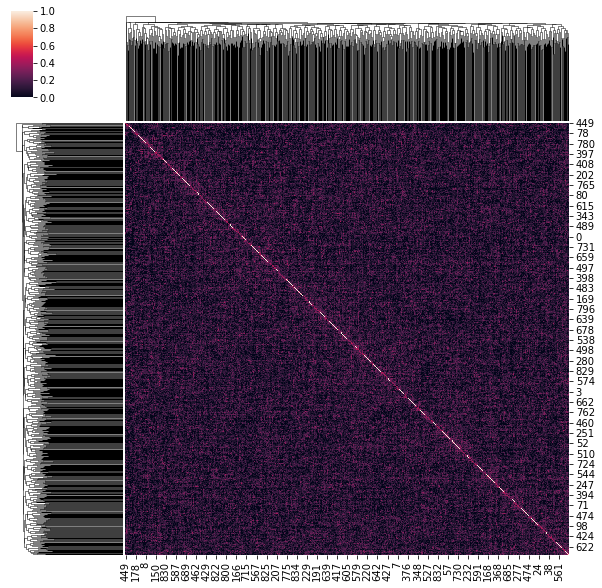

# Dimensionality reduction on cheeses features

In [212]:
features_matrix[filtered_indexes].shape

(836, 125)

0.85998577376416119

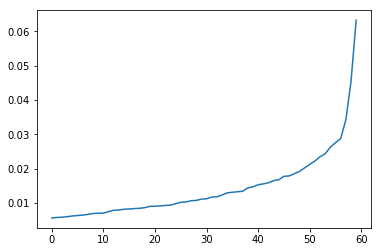

In [398]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=60, n_iter=7, random_state=42)
tsvd.fit(features_matrix[filtered_indexes])                 
# PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,svd_solver='full', tol=0.0, whiten=False)
plt.plot(np.sort(tsvd.explained_variance_ratio_))  
sum(tsvd.explained_variance_ratio_)

The descriptors are fairly independent! 

No clear benefit using TruncatedSVD since the explained variance is very homogenously spread betwenn cheese descriptor

## Cheese.com pairings scraping 

In [238]:
def get_description(self):
    self.get_soup()
    cheese_dict = {'name': cheese.url_name}
    summary_points = self.soup.find_all("ul", {"class": "summary-points"})
    features_list = [x.text for x in summary_points[0].find_all("p")]
    for feature in features_list:
        if ":" in feature:
            split_feature = feature.split(":")
            feature_key = split_feature[0].lower().replace(" ","_")
            feature_val = split_feature[1].strip().lower()
            cheese_dict[feature_key]=feature_val
        elif "Made from" in feature:
            feature_key = 'ingredients'
            feature_val = feature.split("Made from")[1].lower()
            cheese_dict[feature_key]=feature_val.strip()
        else:
            self.dump.append(feature)
    return cheese_dict

{'aroma': 'aromatic',
 'colour': 'pale yellow',
 'country_of_origin': 'canada',
 'family': 'camembert',
 'flavour': 'buttery, creamy',
 'ingredients': "pasteurized cow's milk",
 'name': 'camembert-de-portneuf',
 'producers': 'la maison alexis de portneuf inc.',
 'region': 'quebec',
 'rind': 'bloomy',
 'texture': 'creamy, soft-ripened and supple',
 'type': 'soft, soft-ripened'}

In [302]:
name = random.choice(list(filtered_df['name']))
print(name)
cheese = RawCheese(name)
cheese.get_soup()
description = cheese.soup.find_all("div", {"class": "description"})
if "pair" in description[0].text.lower():
    pos = description[0].text.lower().find("pair")
    print(description[0].text[pos-30:pos+30])
else:
    print('nope')
    


golden-cross
nope


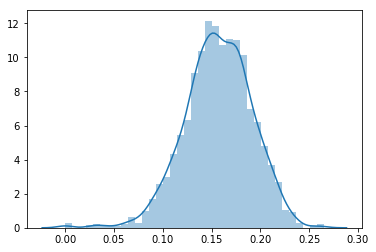

In [104]:
mean_vec = np.mean(cheeses.get_cosine_similarity_matrix(),axis=0)
sns.distplot(mean_vec)

## let's  get rid of the cheeses that have an average cosine_similarity less than 0.1

In [126]:
friendly_cheeses_indexes = np.argwhere(mean_vec>=.1)
cheeses.raw_df.loc[friendly_cheeses_indexes.flatten()]

,name,aroma,colour,country_of_origin,family,flavour,ingredients,producers,region,rind,texture,type,vegetarian,synonyms,fat_content,alternative_spellings,calcium_content,fat_content_(in_dry_matter)
0,Kabritt,"earthy, rich",ivory,canada,tomme,"buttery, salty, tangy",pasteurized goat's milk,the farm house natural cheeses,british columbia,natural,buttery,"hard, artisan",no,NaN,NaN,NaN,NaN,NaN
1,abbaye-de-belloc,lanoline,yellow,france,NaN,burnt caramel,unpasteurized cow's and sheep's milk,abbaye de notre-dame de belloc,pays basque,natural,"creamy, dense and firm","semi-hard, artisan",yes,abbaye notre-dame de belloc,NaN,NaN,NaN,NaN
3,abbaye-de-citeaux,"barnyardy, earthy",white,france,NaN,"acidic, milky, smooth",unpasteurized cow's milk,frères frédéric and joel,burgundy,washed,"creamy, dense and smooth","semi-soft, artisan, brined",no,NaN,NaN,NaN,NaN,NaN
4,abbaye-de-timadeuc,NaN,pale yellow,france,NaN,NaN,pasteurized cow's milk,NaN,province of brittany,washed,soft,semi-hard,no,NaN,NaN,NaN,NaN,NaN
5,abbaye-du-mont-des-cats,floral,pale yellow,france,NaN,"milky, salty",pasteurized cow's milk,abbaye du mont des cats,nord-pas-de-calais,washed,smooth and supple,"semi-soft, artisan, brined",no,NaN,50%,NaN,NaN,NaN
6,abbots-gold,aromatic,pale yellow,"england, great britain and united kingdom",cheddar,"mild, sweet, tangy",pasteurized cow's milk,wensleydale creamery,north yorkshire,natural,"creamy, crumbly, dense and semi firm",semi-hard,yes,"english cheddar with caramelized onions, caram...",NaN,NaN,NaN,NaN
7,abertam,NaN,pale yellow,czech republic,NaN,"acidic, strong, tangy",sheep's milk,NaN,karlovy vary,natural,firm,"hard, artisan",no,NaN,45%,NaN,NaN,NaN
8,abondance,nutty,pale yellow,france,tomme,"acidic, buttery, fruity, sweet",unpasteurized cow's milk,NaN,"haute-savoie, abondance",natural,"creamy, open and supple","semi-hard, artisan",no,NaN,48%,tomme d'abondance,NaN,NaN
9,acapella,"fresh, herbal",NaN,united states,NaN,buttery,goat's milk,andante dairy,california,NaN,NaN,"soft, soft-ripened",no,NaN,NaN,NaN,NaN,NaN
10,accasciato,"aromatic, fresh",pale yellow,italy,NaN,sweet,buffalo's and cow's milk,casa madaio,campania,natural,firm,semi-hard,no,NaN,NaN,NaN,NaN,NaN


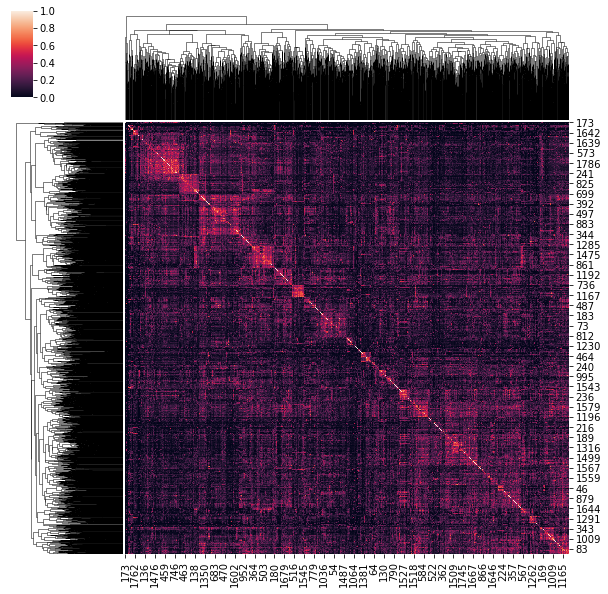

In [41]:
g = sns.clustermap(cosine)

## Pick random cheese and suggest ten closest 

In [49]:
sim_matrix = cheeses.get_cosine_similarity_matrix()

In [68]:
cheese_index = random.randint(0,len(cheeses.raw_df)-1)
cheeses.raw_df.iloc[cheese_index]

name                                             pigouille
aroma                                            barnyardy
colour                                               ivory
country_of_origin                                   france
family                                                 NaN
flavour                        acidic, salty, sweet, tangy
ingredients                     unpasteurized sheep's milk
producers                                              NaN
region                                           charentes
rind                                          mold ripened
texture                         creamy, crumbly and grainy
type                                         soft, artisan
vegetarian                                             NaN
synonyms                                               NaN
fat_content                                            NaN
alternative_spellings              pigouille des charentes
calcium_content                                        N

In [69]:
for index in np.argsort(sim_matrix[cheese_index])[-4:-1]:
    print(cheeses.raw_df.iloc[index])

name                                                                cabrales
aroma                                                                 strong
colour                                                                  blue
country_of_origin                                                      spain
family                                                                  blue
flavour                                                 acidic, salty, sharp
ingredients                     unpasteurized cow's, goat's and sheep's milk
producers                                                                NaN
region                                                              asturias
rind                                                            mold ripened
texture                                                      creamy and firm
type                                         semi-hard, artisan, blue-veined
vegetarian                                                                no

In [ ]:
import numpy as np
from sklearn import manifold
model = manifold.TSNE(metric="precomputed",n_components=3)
Y = model.fit_transform(cheeses.get_similarity_matrix())


In [323]:
len(filtered_df)

836

## t-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
from sklearn.manifold import TSNE

In [447]:
features_embedded = TSNE(n_components=2).fit_transform(features_matrix[filtered_indexes,:].toarray())

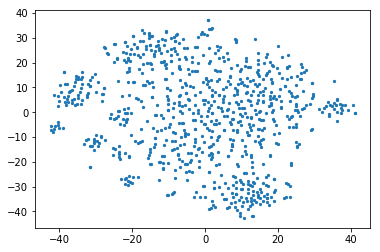

In [449]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(features_embedded[:,0],features_embedded[:,1], s=5, cmap='hsv')



## With TruncatedSVD

In [450]:
tsvd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
tsvd.fit(features_matrix[filtered_indexes])              

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=7,
       random_state=42, tol=0.0)

In [ ]:
features_embedded = TSNE(n_components=2).fit_transform(tsvd.fit_transform(features_matrix[filtered_indexes,:]))

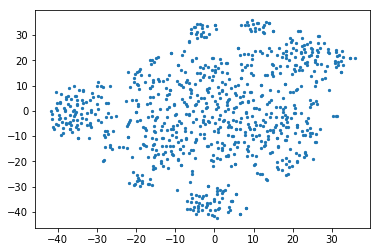

In [454]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(features_embedded[:,0],features_embedded[:,1], s=5, cmap='hsv')



# Wines

In [ ]:
"https://www.winemag.com/?s=&drink_type=wine&wine_type=Red,White&rating=94.0-97.99,98.0-*,90.0-93.99,83.0-86.99,87.0-89.99&price=1.0-15.99,16.0-25.99&pub_date_web=2018&page=1"

## Collecting wikipedia wine descriptors


Collected a list of wine descriptors from https://en.wikipedia.org/wiki/Wine_tasting_descriptors, removed "fallen over for simplicity, and wrote them in wiki_wine_descriptors



In [388]:
start = False
stop = False
for walla in wine_descriptors_soup.find_all("div", {"id": "bodyContent"})[0].find_all("li"):
    print(walla.contents[0].contents[0])
        
        
       

<span class="tocnumber">1</span>
<span class="tocnumber">2</span>
<span class="tocnumber">3</span>
<span class="tocnumber">4</span>
<span class="tocnumber">5</span>
<span class="tocnumber">6</span>
<span class="tocnumber">7</span>
Acidic
Aftertaste
Alcoholic
Aroma
Astringent
Autolytic
Baked
Balanced
Big
Bitter
Body
Bouquet
Brilliance
Buttery
Chewy
Chocolaty
Closed
Cloying
Coarse
Complex
Concentrated
Connected
Corked
Crisp
Depth
Dirty
Dry
Earthy
Elegant
Expressive
Extracted
Fallen over
Fat
Finesse
Finish
Firm
Flabby
Flat
Foxy
Fresh
Fruit
Full
Grassy
Green
Hard
Heavy
Herbal
Herbaceous
Hollow
Hot
Jammy
Lean
Leathery
Legs
Musty
Nose
Oaky
Oxidized
Oxidative
Petrolly
Powerful
Raisiny
Reticent
Rich
Rough
Round
Smokey
Smooth
Soft
Sour
Spicy
Supple
Sweet
Tannic
Tar
Tart
Toasty
Transparency
Typicity
Vanillin
Vegetal
Vinegary
<a class="image" href="/wiki/File:Glass_of_wine.png"><img alt="icon" class="noviewer" data-file-height="161" data-file-width="151" height="28" src="//upload.wikimedia.org/wi

I just copied and pasted the list in a .txt file

In [26]:
wine_descriptors = []
with open("wiki_wine_descriptors.txt","r") as f:
    for line in f:
        wine_descriptors.append(line.lower().strip('\n'))
len(wine_descriptors)

81

In [2]:
wines = pd.read_csv("winemag-data-130k-v2.csv", index_col=0)


In [8]:
def simple_wine_tokenizer(sentence):
        remove_list = ["'s","milk"]+["palate",'include',"the"]
        sep_list = [" and "," or ","."]
        for pattern in remove_list:
            sentence = sentence.lower().replace(pattern,"")
        for pattern in sep_list:
            sentence = sentence.replace(pattern,",")
        sentence = sentence.replace(" ",",")
        return [word.strip() for word in sentence.split(",") if len(word)>1]

## How many wine varieties?

In [69]:
varieties = list(wines['variety'])
print("There is {} unique wine varieties in this list".format(len(set(varieties))))
n_popular = 50
varieties.remove(np.nan)
varieties

There is 708 unique wine varieties in this list


['White Blend',
 'Portuguese Red',
 'Pinot Gris',
 'Riesling',
 'Pinot Noir',
 'Tempranillo-Merlot',
 'Frappato',
 'Gewürztraminer',
 'Gewürztraminer',
 'Pinot Gris',
 'Cabernet Sauvignon',
 'Gewürztraminer',
 'Cabernet Sauvignon',
 'Nerello Mascalese',
 'Chardonnay',
 'Riesling',
 'Malbec',
 'Malbec',
 'Tempranillo Blend',
 'Meritage',
 'Red Blend',
 'Pinot Noir',
 'White Blend',
 'Merlot',
 "Nero d'Avola",
 'Pinot Noir',
 'White Blend',
 "Nero d'Avola",
 'Red Blend',
 'Chenin Blanc',
 'Gamay',
 'Red Blend',
 'White Blend',
 'Red Blend',
 'Sauvignon Blanc',
 'Pinot Noir',
 'Viognier-Chardonnay',
 'Cabernet Sauvignon',
 'Primitivo',
 "Nero d'Avola",
 'Catarratto',
 'Pinot Noir',
 'Gamay',
 'Sauvignon Blanc',
 'Merlot',
 'Red Blend',
 'Inzolia',
 'Riesling',
 'Sauvignon Blanc',
 'Gamay',
 'Red Blend',
 'Petit Verdot',
 'Monica',
 'Bordeaux-style White Blend',
 'Red Blend',
 'Chardonnay',
 'Chardonnay',
 'Grillo',
 'Pinot Noir',
 'Malbec',
 'Cabernet Sauvignon',
 'Sangiovese',
 'Cabernet

(0.8, 1)

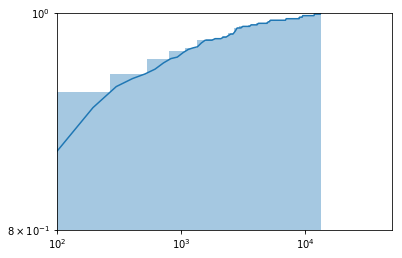

In [186]:
variety_cnt = Counter()
for variety in wines['variety']:
    variety_cnt[variety] += 1


variety_cnt
sorted_varieties = dict(sorted(variety_cnt.items(), key=lambda x: x[1]))
values = [x for x in variety_cnt.values()]
sns.distplot(values,hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True))
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlim([100, 50000])
plt.ylim([0.8, 1])

In [71]:
n_items_thresh = 500
vals_above_thresh = [value for value in values if value >n_items_thresh]

print("There are {} varieties of wines with more than {} entries in the DB. Total is {}".format(
    len(vals_above_thresh),
    n_items_thresh,
    sum(vals_above_thresh)
     ))

There are 40 varieties of wines with more than 500 entries in the DB. Total is 111797


In [196]:
top_varieties = {k:v for k,v in dict(variety_cnt).items() if v>50}
top_varieties

{'Agiorgitiko': 63,
 'Aglianico': 359,
 'Albariño': 477,
 'Alsace white blend': 51,
 'Alvarinho': 137,
 'Arinto': 77,
 'Arneis': 86,
 'Austrian Red Blend': 62,
 'Austrian white blend': 80,
 'Barbera': 721,
 'Blaufränkisch': 232,
 'Bonarda': 105,
 'Bordeaux-style Red Blend': 6915,
 'Bordeaux-style White Blend': 1066,
 'Cabernet Blend': 80,
 'Cabernet Franc': 1353,
 'Cabernet Sauvignon': 9472,
 'Cabernet Sauvignon-Merlot': 117,
 'Cabernet Sauvignon-Syrah': 102,
 'Carignan': 77,
 'Carmenère': 575,
 'Champagne Blend': 1396,
 'Chardonnay': 11753,
 'Chenin Blanc': 591,
 'Cortese': 73,
 'Corvina, Rondinella, Molinara': 619,
 'Dolcetto': 180,
 'Falanghina': 89,
 'Fiano': 151,
 'Friulano': 122,
 'Fumé Blanc': 70,
 'Furmint': 55,
 'G-S-M': 181,
 'Gamay': 1025,
 'Garganega': 270,
 'Garnacha': 326,
 'Gewürztraminer': 1012,
 'Glera': 709,
 'Godello': 81,
 'Greco': 121,
 'Grenache': 651,
 'Grenache Blanc': 131,
 'Grillo': 137,
 'Gros and Petit Manseng': 51,
 'Grüner Veltliner': 1345,
 'Lagrein': 80,

In [197]:
corpus = dict.fromkeys(varieties,[])
for variety in top_varieties:
    print(variety)
    wines[wines['variety']==variety].apply(lambda x: corpus[variety].append(clean_tokenizer(x["description"])),axis = 1)

White Blend
Portuguese Red
Pinot Gris
Riesling
Pinot Noir
Gewürztraminer
Cabernet Sauvignon
Nerello Mascalese
Chardonnay
Malbec
Tempranillo Blend
Meritage
Red Blend
Merlot
Nero d'Avola
Chenin Blanc
Gamay
Sauvignon Blanc
Primitivo
Petit Verdot
Bordeaux-style White Blend
Grillo
Sangiovese
Cabernet Franc
Champagne Blend
Bordeaux-style Red Blend
Aglianico
Petite Sirah
Touriga Nacional
Carmenère
Albariño
Petit Manseng
Rosé
Zinfandel
Vernaccia
Rosato
Grüner Veltliner
Viognier
Vermentino
Grenache Blanc
Syrah
Nebbiolo
Pinot Blanc
Alsace white blend
Barbera
Rhône-style Red Blend
Portuguese White
Sauvignon
Sangiovese Grosso
Torrontés
G-S-M
Verdejo
Fumé Blanc
Furmint
Pinot Bianco
Bonarda
Shiraz
Montepulciano
Moscato
Grenache
Blaufränkisch
Friulano
Sagrantino
Cabernet Sauvignon-Syrah
Prosecco
Sparkling Blend
Muscat
Garganega
Pinot Grigio
Tempranillo
Cortese
Mencía
Zweigelt
Melon
Rhône-style White Blend
Verdelho
Marsanne
Syrah-Grenache
Dolcetto
Glera
Viura
Pinot Nero
Pinotage
Sémillon
Verdicchio
Sy

In [192]:
wines[wines['variety']=="Red Blend"].count()

country                  0
description              0
designation              0
points                   0
price                    0
province                 0
region_1                 0
region_2                 0
taster_name              0
taster_twitter_handle    0
title                    0
variety                  0
winery                   0
dtype: int64

In [10]:


clean_tokenizer(wines["description"][random.randint(0,n_wines)].lower())

['good',
 'useful',
 'red',
 'blend',
 'little',
 'green',
 'peppermint',
 'spicy',
 'dry',
 'berry',
 'cola',
 'flavors',
 'fine',
 'full-bodied',
 'house',
 'wine']

In [101]:
wines_2016 = wines[wines['title'].map(lambda x: '2016' in x)]
len(wines_2016)
start_time = time.time()
corpus_2016 = wines_2016["description"].map(clean_tokenizer)
print("--- %s seconds ---" % (time.time() - start_time))


--- 3.1496059894561768 seconds ---


In [42]:
wine_vocab_2016 = list()
wines_2016.apply(lambda x: wine_vocab_2016.append(clean_tokenizer(x["description"])),axis = 1)

77        None
82        None
83        None
86        None
574       None
577       None
579       None
580       None
581       None
584       None
585       None
586       None
587       None
590       None
591       None
593       None
597       None
1080      None
1081      None
1086      None
1208      None
1214      None
1316      None
1319      None
1320      None
1322      None
1335      None
1337      None
1338      None
1339      None
          ... 
129302    None
129304    None
129309    None
129311    None
129315    None
129317    None
129319    None
129413    None
129414    None
129423    None
129425    None
129428    None
129434    None
129437    None
129438    None
129440    None
129441    None
129442    None
129443    None
129444    None
129449    None
129451    None
129452    None
129453    None
129454    None
129457    None
129556    None
129572    None
129718    None
129907    None
Length: 3691, dtype: object

In [44]:
len(wine_vocab_2016)

6235

11

In [28]:
import timeit

In [218]:
corpus['Gamay']

[['aromas',
  'include',
  'tropical',
  'fruit',
  'broom',
  'brimstone',
  'dried',
  'herb',
  'palate',
  "n't",
  'overly',
  'expressive',
  'offering',
  'unripened',
  'apple',
  'citrus',
  'dried',
  'sage',
  'alongside',
  'brisk',
  'acidity'],
 ['delicate',
  'aromas',
  'recall',
  'white',
  'flower',
  'citrus',
  'palate',
  'offers',
  'passion',
  'fruit',
  'lime',
  'white',
  'peach',
  'hint',
  'mineral',
  'alongside',
  'bright',
  'acidity'],
 ['pretty',
  'aromas',
  'yellow',
  'flower',
  'stone',
  'fruit',
  'lead',
  'nose',
  'bright',
  'palate',
  'offers',
  'yellow',
  'apple',
  'apricot',
  'vanilla',
  'delicate',
  'notes',
  'lightly',
  'toasted',
  'oak',
  'alongside',
  'crisp',
  'acidity'],
 ['part',
  'extended',
  'calanìca',
  'series',
  'grillo-viognier',
  'blend',
  'shows',
  'aromas',
  'honeysuckle',
  'jasmine',
  'backed',
  'touches',
  'cut',
  'grass',
  'wild',
  'sage',
  'mouth',
  'shows',
  'ripe',
  'yellow-fruit',

In [20]:
wines.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [98]:
# Pooled list of tokens in the 2016 wines description
corpus_2016_list = []
wines_2016.apply(lambda x: corpus_2016_list.extend(clean_tokenizer(x["description"])),axis = 1)
print('')

In [100]:
print("There are {} words in the 2016 wine corpus and {} unique ones".format(len(corpus_2016_list), len(set(corpus_2016_list))))

There are 84031 words in the 2016 wine corpus and 6235 unique ones


In [78]:
from collections import Counter
cnt = Counter()
for word in corpus_2016_list:
    cnt[word] += 1


In [72]:
cnt.__class__

collections.Counter

In [93]:
print(np.max([x for x in cnt.values()]))
print(np.median([x for x in cnt.values()]))

2725
2.0


In [94]:
# amount of overlap between wikipedia wine_descriptors and corpus

145

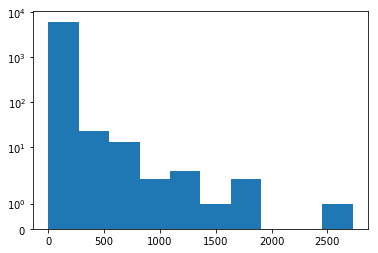

In [96]:
# We probably don't want words that are used very often (not imformative)
plt.hist([x for x in cnt.values()])
plt.yscale('symlog')

# Gensim intro

In [6]:
description = wines.loc[1000]['description']
description

"Arcane's Cab is stylistically apart from either California or Washington. It defines its own space. There's plenty of new oak, but the fruit, acid and tannins stand up to it. This is sharp and tangy; cranberry and raspberry, strawberry and citric acids all playing their part. Still young, give it some time in a decanter or in your cellar to come together and show its best."

In [11]:
clean_tokenizer(description)

['arcane',
 'cab',
 'stylistically',
 'apart',
 'either',
 'california',
 'washington',
 'defines',
 'space',
 'plenty',
 'new',
 'oak',
 'fruit',
 'acid',
 'tannins',
 'stand',
 'sharp',
 'tangy',
 'cranberry',
 'raspberry',
 'strawberry',
 'citric',
 'acids',
 'playing',
 'part',
 'still',
 'young',
 'give',
 'time',
 'decanter',
 'cellar',
 'come',
 'together',
 'show',
 'best']

In [22]:
descriptions = wines['description'].apply(clean_tokenizer).tolist()

In [23]:
vec_size = 80
model = gensim.models.Word2Vec(
        descriptions,
        size=vec_size,
        window=6,
        min_count=9,
        workers=8)
model.train(descriptions, total_examples=len(descriptions), epochs=10)

(27214214, 32244700)

In [185]:
word = 'dry'#random.choice(wine_descriptors)
print(word)
model.wv.most_similar(word,topn=1000)

dry


/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dryness', 0.632988452911377),
 ('bone-dry', 0.5842207670211792),
 ('off-dry', 0.45334261655807495),
 ('sweet', 0.42141959071159363),
 ('fine', 0.41001951694488525),
 ('ripe', 0.4046674370765686),
 ('bite', 0.40383923053741455),
 ('drier', 0.3953487277030945),
 ('framing', 0.39349526166915894),
 ('scour', 0.3816501498222351),
 ('dryish', 0.3721069097518921),
 ('rich', 0.3720286190509796),
 ('cutting', 0.3714490532875061),
 ('brightened', 0.34607893228530884),
 ('flavors', 0.3426586985588074),
 ('dominate', 0.3404986262321472),
 ('semidry', 0.3326350748538971),
 ('brisk', 0.3315303921699524),
 ('astringency', 0.33063533902168274),
 ('filled', 0.32844778895378113),
 ('drily', 0.32662233710289),
 ('accenting', 0.3264610767364502),
 ('fruity', 0.32233256101608276),
 ('hinting', 0.32155078649520874),
 ('concentrated', 0.3213460445404053),
 ('minerals', 0.3202415108680725),
 ('ready', 0.31991010904312134),
 ('semi-sweet', 0.31919926404953003),
 ('good', 0.3185597062110901),
 ('shot', 0.317

In [49]:
description_1 = wines['description'].loc[0]


In [59]:
mean_vec = np.mean(model.wv[['stemmy','barnyard']],axis=0)
mean_vec

array([ 0.722976  ,  2.0459433 ,  1.0230926 ,  1.0373492 ,  0.14701307,
       -0.9036116 ,  0.5509055 ,  0.24097729, -1.3934375 , -1.2270567 ,
       -0.03162444, -1.7010782 , -0.51399815,  0.84962827,  0.8580046 ,
        0.10892454,  0.12276888, -1.0607396 ,  1.7811884 ,  1.4479775 ,
       -2.4852738 ,  1.2701962 ,  0.8385344 ,  0.14862299, -0.5044217 ,
       -0.18411998, -0.05205866, -2.1583166 , -0.1163134 ,  0.22057965,
       -0.44282123, -0.89859164,  2.3317301 ,  0.73483694,  0.29417565,
        1.1984754 , -0.16897902,  0.2701801 , -0.7837309 , -0.30857825,
       -1.5921857 , -0.6388775 , -0.79551846, -1.1313268 , -2.385797  ,
        0.5172587 ,  2.5958254 , -0.8807342 , -1.855293  ,  1.5296282 ,
       -0.54135066, -2.576578  ,  0.12255155,  0.25254077,  1.5895154 ,
        1.2336054 ,  1.3299829 ,  0.24890462,  0.0458442 , -2.2633905 ,
        0.3908787 , -0.34437525,  0.39164436, -0.6717231 ,  0.6302167 ,
        3.4143295 , -1.0433519 ,  0.5670384 , -0.26942873, -0.10

In [110]:
def descriptions_similarity(desc1,desc2,**kwargs):
    vocab = kwargs.pop('vocab',None)
    if vocab:
        desc1 = list(set(desc1).intersection(vocab))
        desc2 = list(set(desc2).intersection(vocab))
    mean_vec1 = np.mean(model.wv[desc1],axis=0)
    mean_vec2 = np.mean(model.wv[desc2],axis=0)
    return cosine(mean_vec1, mean_vec2)

In [98]:
# for variety in top_varieties
random.choice(list(top_varieties.keys()))

'Nebbiolo'

In [100]:
random.choice(corpus["Nebbiolo"])

['young',
 'tastes',
 'like',
 'still',
 'fermenting',
 'bad',
 'wine',
 'freshly',
 'tart',
 'strong',
 'grapy',
 'flavors',
 'calm',
 'mid-2011',
 'become',
 'nice',
 'full-bodied',
 'dry',
 'red',
 'wine']

In [116]:
desc1 = random.choice(corpus["Nebbiolo"])
desc2 = random.choice(corpus["Gamay"])                     
descriptions_similarity(desc1,desc2,vocab=list(model.wv.vocab.keys()))

1.211880043318887

In [117]:
desc1

['heavily',
 'oaked',
 'carmenère',
 'aromas',
 'caramel',
 'vanilla',
 'licorice',
 'share',
 'space',
 'bouquet',
 'stewed',
 'foresty',
 'notes',
 'plump',
 'saturated',
 'feel',
 'mellow',
 'soft',
 'tough',
 'tannic',
 'roasted',
 'blackberry',
 'toast',
 'spicy',
 'oak',
 'flavors',
 'end',
 'big',
 'heavily',
 'leftover',
 'oak',
 'herbal',
 'notes',
 'drink']

In [118]:
desc2

['terrific',
 'value',
 'wine',
 'rosé',
 'made',
 'indigenous',
 'grapes',
 'sicily',
 'opens',
 'bright',
 'pink',
 'color',
 'fragrant',
 'tones',
 'raspberry',
 'white',
 'almond',
 'rose',
 'petal']

In [131]:
wine_descriptors

['acidic',
 'aftertaste',
 'alcoholic',
 'aroma',
 'astringent',
 'autolytic',
 'baked',
 'balanced',
 'big',
 'bitter',
 'body',
 'bouquet',
 'brilliance',
 'buttery',
 'chewy',
 'chocolaty',
 'closed',
 'cloying',
 'coarse',
 'complex',
 'concentrated',
 'connected',
 'corked',
 'crisp',
 'depth',
 'dirty',
 'dry',
 'earthy',
 'elegant',
 'expressive',
 'extracted',
 'fat',
 'finesse',
 'finish',
 'firm',
 'flabby',
 'flat',
 'foxy',
 'fresh',
 'fruit',
 'full',
 'grassy',
 'green',
 'hard',
 'heavy',
 'herbal',
 'herbaceous',
 'hollow',
 'hot',
 'jammy',
 'lean',
 'leathery',
 'legs',
 'musty',
 'nose',
 'oaky',
 'oxidized',
 'oxidative',
 'petrolly',
 'powerful',
 'raisiny',
 'reticent',
 'rich',
 'rough',
 'round',
 'smokey',
 'smooth',
 'soft',
 'sour',
 'spicy',
 'supple',
 'sweet',
 'tannic',
 'tar',
 'tart',
 'toasty',
 'transparency',
 'typicity',
 'vanillin',
 'vegetal',
 'vinegary']

In [127]:
names = cheeses.raw_df['name']

In [130]:
wines['description'].loc[123434]

'Very perfumed, this is a spicy Traminer with an amount of sweetness. The wine is ripe and rounded, with dominant tropical fruit. The acidity cuts through the richness. Screwcap.'

In [164]:
wines[(wines['variety']=='Chardonnay') & (wines['country']=='France')]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
65,France,"From the warm 2015 vintage, this is a soft and...",NaN,86,24.0,Burgundy,Chablis,NaN,Roger Voss,@vossroger,Simonnet-Febvre 2015 Chablis,Chardonnay,Simonnet-Febvre
66,France,"This soft, rounded wine is ripe with generous ...",NaN,86,15.0,Burgundy,Mâcon-Milly Lamartine,NaN,Roger Voss,@vossroger,Vignerons des Terres Secrètes 2015 Mâcon-Mill...,Chardonnay,Vignerons des Terres Secrètes
179,France,The impact of 50-year old vines is seen in the...,Les Vénérables Vieilles Vignes,88,27.0,Burgundy,Chablis,NaN,Roger Voss,@vossroger,La Chablisienne 2006 Les Vénérables Vieilles V...,Chardonnay,La Chablisienne
193,France,"A citrus-dominated wine, lime and lemon giving...",NaN,87,35.0,Burgundy,St.-Romain,NaN,Roger Voss,@vossroger,Bertrand Ambroise 2006 St.-Romain,Chardonnay,Bertrand Ambroise
353,France,"This beautiful, rich wine has yellow fruits an...",Le Montrachet,96,630.0,Burgundy,Montrachet,NaN,Roger Voss,@vossroger,Louis Latour 2014 Le Montrachet (Montrachet),Chardonnay,Louis Latour
359,France,Up the slope above the Grand Cru of Le Montrac...,Les Chenevottes Premier Cru,95,110.0,Burgundy,Chassagne-Montrachet,NaN,Roger Voss,@vossroger,Philippe Colin 2014 Les Chenevottes Premier Cr...,Chardonnay,Philippe Colin
363,France,This is an opulent wine from one of the fabled...,NaN,95,380.0,Burgundy,Criots-Bâtard-Montrachet,NaN,Roger Voss,@vossroger,Louis Latour 2014 Criots-Bâtard-Montrachet,Chardonnay,Louis Latour
452,France,Aromas of wood aging and ripe yellow fruits ar...,Les Tillets,92,NaN,Burgundy,Meursault,NaN,Roger Voss,@vossroger,Patrick Javillier 2011 Les Tillets (Meursault),Chardonnay,Patrick Javillier
462,France,"This big, ripe and fruity wine shows both the ...",Blagny Premier Cru,92,66.0,Burgundy,Meursault,NaN,Roger Voss,@vossroger,Henri de Villamont 2010 Blagny Premier Cru (M...,Chardonnay,Henri de Villamont
466,France,"Crisp and structured, this is an intensely min...",Blanc de Blancs Brut,92,NaN,Champagne,Champagne,NaN,Roger Voss,@vossroger,Deutz 2007 Blanc de Blancs Brut Chardonnay (Ch...,Chardonnay,Deutz
